## NFStream preprocess


### Dataset Construction


In [245]:
from nfstream import NFStreamer, NFPlugin
import pandas as pd

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)


In [246]:
miningFlows = NFStreamer(
    source="./mergedMining.pcap", statistical_analysis=True
).to_pandas()
whiteFlows = NFStreamer(
    source="./mergedWhite.pcap", statistical_analysis=True
).to_pandas()
miningFlows["label"] = 1
whiteFlows["label"] = 0
flows = pd.concat([miningFlows, whiteFlows])
# print(flows.to_pandas().shape[0])


In [247]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    flows.iloc[:, 9:-8].drop(
        [
            "application_name",
            "application_category_name",
            "bidirectional_first_seen_ms",
            "bidirectional_last_seen_ms",
            "src2dst_first_seen_ms",
            "src2dst_last_seen_ms",
            "dst2src_first_seen_ms",
            "dst2src_last_seen_ms",
        ],
        axis=1,
    ),
    flows.iloc[:, -1],
    test_size=0.6,
    random_state=6,
)


In [248]:
train_X.head()


,dst_port,protocol,ip_version,vlan_id,tunnel_id,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets
34,41692,6,4,0,0,450923,51,9953,450923,26,6881,450923,25,3072,54,195.156863,175.979246,489,60,264.653846,198.721905,489,54,122.880000,112.731362,300,0,9018.460000,17010.885128,60182,1,18036.920000,20527.527548,60182,390,18788.458333,20614.161534,60182,0,0,0,0,51,25,0,2,0,0,0,0,26,18,0,1,0,0,0,0,25,7,0,1
11,443,6,4,0,0,120158,20,6017,120140,9,1356,120141,11,4661,54,300.850000,450.124693,1514,54,150.666667,178.004916,571,60,423.727273,568.072547,1514,0,6324.105263,27514.560953,119945,0,15017.500000,42397.135402,119945,0,12014.100000,37942.030404,119999,2,0,0,0,19,7,0,2,1,0,0,0,8,3,0,1,1,0,0,0,11,4,0,1
166,443,6,4,0,0,15054,18,6577,15000,9,2008,15034,9,4569,54,365.388889,480.547254,1494,54,223.111111,311.771328,921,60,507.666667,589.888973,1494,0,885.529412,3604.785051,14874,0,1875.000000,5252.836975,14875,0,1879.250000,5252.330551,14878,2,0,0,0,17,6,1,2,1,0,0,0,8,3,1,1,1,0,0,0,9,3,0,1
295,443,6,4,0,0,4391,21,6257,4391,11,1759,4379,10,4498,54,297.952381,436.935404,1514,54,159.909091,173.257874,571,60,449.800000,584.795843,1514,0,219.550000,713.610721,3157,1,439.100000,985.346126,3157,0,486.555556,1061.176483,3211,2,0,0,0,20,7,0,2,1,0,0,0,10,4,0,1,1,0,0,0,10,3,0,1
24,9000,6,4,0,0,1752248,266,50940,1752248,134,18088,1750835,132,32852,54,191.503759,185.176840,1389,54,134.985075,116.444829,401,60,248.878788,221.393885,1389,0,6612.256604,13892.867853,60834,0,13174.796992,17289.044026,60834,0,13365.152672,17352.843093,60834,3,0,0,0,264,131,0,0,2,0,0,0,132,44,0,0,1,0,0,0,132,87,0,0


In [249]:
train_y.head(10)


34     1
11     0
166    0
295    0
24     1
215    0
191    1
254    1
20     0
231    0
Name: label, dtype: int64

In [250]:
RF_means = []
FCNN_means = []
LR_means = []
CART_means = []


### Feature Importance Analyzation


In [251]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(train_X.values, train_y)


RandomForestClassifier(random_state=42)

In [252]:
from sklearn.metrics import recall_score, precision_score, f1_score

predict = model.predict(test_X.values)
print(f"Recall score:       {recall_score(y_pred=predict, y_true=test_y)}")
print(f"Precision score:    {precision_score(y_pred=predict, y_true=test_y)}")
print(f"F1 score:           {f1_score(y_pred=predict, y_true=test_y)}")


Recall score:       0.9936708860759493
Precision score:    1.0
F1 score:           0.9968253968253968


In [253]:
test_y.head()


15     1
10     1
79     1
134    1
93     1
Name: label, dtype: int64

In [254]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
featureColumns = []
labels = flows.columns[9:-8].drop(
    [
        "application_name",
        "application_category_name",
        "bidirectional_first_seen_ms",
        "bidirectional_last_seen_ms",
        "src2dst_first_seen_ms",
        "src2dst_last_seen_ms",
        "dst2src_first_seen_ms",
        "dst2src_last_seen_ms",
    ]
)
for f in range(len(labels)):
    print(
        "%2d) %-*s %f" % (f + 1, 30, labels[indices[f]], importances[indices[f]]),
        f"    ColumnIndex:  {flows.columns.get_loc(labels[indices[f]])}",
    )
    if importances[indices[f]] > 0.0003:
        featureColumns.append(flows.columns.get_loc(labels[indices[f]]))

print(featureColumns)


 1) dst2src_duration_ms            0.114650     ColumnIndex:  26
 2) src2dst_syn_packets            0.111861     ColumnIndex:  61
 3) src2dst_duration_ms            0.101703     ColumnIndex:  21
 4) bidirectional_duration_ms      0.068716     ColumnIndex:  16
 5) bidirectional_syn_packets      0.059393     ColumnIndex:  53
 6) bidirectional_mean_piat_ms     0.046220     ColumnIndex:  42
 7) bidirectional_stddev_ps        0.043361     ColumnIndex:  31
 8) src2dst_min_ps                 0.042222     ColumnIndex:  33
 9) src2dst_psh_packets            0.038513     ColumnIndex:  66
10) bidirectional_max_ps           0.030121     ColumnIndex:  32
11) bidirectional_fin_packets      0.029208     ColumnIndex:  60
12) dst2src_syn_packets            0.025407     ColumnIndex:  69
13) src2dst_packets                0.023459     ColumnIndex:  22
14) bidirectional_ack_packets      0.021279     ColumnIndex:  57
15) bidirectional_mean_ps          0.020953     ColumnIndex:  30
16) bidirectional_packets

In [255]:
print(f"RF: {RF_means}")
print(f"CART: {CART_means}")
print(f"ID3: {LR_means}")
print(f"FCNN: {FCNN_means}")


RF: []
CART: []
ID3: []
FCNN: []


## Random Forest(After Feature choosen)


In [256]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    flows.iloc[:, :],
    flows.iloc[:, -1],
    test_size=0.2,
    random_state=5,
)


In [257]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(train_X.iloc[:, featureColumns].values, train_y)


RandomForestClassifier(random_state=42)

In [258]:
from sklearn.metrics import recall_score, precision_score, f1_score

predict = model.predict(test_X.iloc[:, featureColumns].values)
print(f"Recall score:       {recall_score(y_pred=predict, y_true=test_y)}")
print(f"Precision score:    {precision_score(y_pred=predict, y_true=test_y)}")
print(f"F1 score:           {f1_score(y_pred=predict, y_true=test_y)}")
RF_means.append(recall_score(y_pred=predict, y_true=test_y))
RF_means.append(precision_score(y_pred=predict, y_true=test_y))
RF_means.append(f1_score(y_pred=predict, y_true=test_y))


itemindex = np.argwhere(predict == 1).T.tolist()[0]
(test_X.iloc[itemindex, :])[
    ["src_ip", "src_port", "dst_ip", "dst_port", "protocol"]
].head()


Recall score:       1.0
Precision score:    0.9791666666666666
F1 score:           0.9894736842105264


,src_ip,src_port,dst_ip,dst_port,protocol
132,91.121.140.167,5555,192.168.1.100,59124,6
140,10.10.22.55,54278,149.202.83.171,443,6
230,10.10.22.55,41430,136.243.49.177,443,6
248,10.10.22.55,41430,136.243.49.177,443,6
116,149.202.83.171,9000,192.168.1.101,48986,6


## CART Decision Tree


In [259]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="gini",random_state=42)
tree.fit(train_X.iloc[:,featureColumns].values, train_y)


DecisionTreeClassifier(random_state=42)

In [260]:
predict = tree.predict(test_X.iloc[:,featureColumns].values)
print(f"Recall score:       {recall_score(y_pred=predict, y_true=test_y)}")
print(f"Precision score:    {precision_score(y_pred=predict, y_true=test_y)}")
print(f"F1 score:           {f1_score(y_pred=predict, y_true=test_y)}")
CART_means.append(recall_score(y_pred=predict, y_true=test_y))
CART_means.append(precision_score(y_pred=predict, y_true=test_y))
CART_means.append(f1_score(y_pred=predict, y_true=test_y))


Recall score:       0.9787234042553191
Precision score:    0.92
F1 score:           0.9484536082474226


## ID3 Decision Tree


In [261]:
# from sklearn.tree import DecisionTreeClassifier

# tree = DecisionTreeClassifier(
#     criterion="entropy", random_state=42
# )
# tree.fit(train_X.iloc[:,featureColumns].values, train_y)


In [262]:
# predict = tree.predict(test_X.iloc[:,featureColumns].values)
# print(f"Recall score:       {recall_score(y_pred=predict, y_true=test_y)}")
# print(f"Precision score:    {precision_score(y_pred=predict, y_true=test_y)}")
# print(f"F1 score:           {f1_score(y_pred=predict, y_true=test_y)}")
# ID3_means.append(recall_score(y_pred=predict, y_true=test_y))
# ID3_means.append(precision_score(y_pred=predict, y_true=test_y))
# ID3_means.append(f1_score(y_pred=predict, y_true=test_y))


## FCNN


In [263]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    flows.iloc[:, 14:-8].drop(
        [
            "application_name",
            "application_category_name",
            "bidirectional_first_seen_ms",
            "bidirectional_last_seen_ms",
            "src2dst_first_seen_ms",
            "src2dst_last_seen_ms",
            "dst2src_first_seen_ms",
            "dst2src_last_seen_ms",
        ],
        axis=1,
    ),
    flows.iloc[:, -1],
    test_size=0.6,
    random_state=6,
)


In [264]:
import torch
from torch.utils.data import Dataset, DataLoader


class StreamDataset(Dataset):
    def __init__(self, X, y):
        # self.X = torch.nn.functional.normalize(torch.tensor(X, dtype=torch.float32),dim=1)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = StreamDataset(train_X.values, train_y)
test_dataset = StreamDataset(test_X.values, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [265]:
np.set_printoptions(threshold=np.inf)
for X, y in train_dataloader:
    print(X)
    break


tensor([[1.7984e+06, 1.5700e+02, 2.7838e+04,  ..., 5.3000e+01, 0.0000e+00,
         0.0000e+00],
        [1.7865e+06, 1.9200e+02, 3.3653e+04,  ..., 6.5000e+01, 0.0000e+00,
         0.0000e+00],
        [1.7884e+06, 2.8600e+02, 5.6451e+04,  ..., 6.3000e+01, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.2194e+05, 2.1000e+01, 4.4080e+03,  ..., 4.0000e+00, 0.0000e+00,
         1.0000e+00],
        [1.7719e+06, 1.4900e+02, 2.7272e+04,  ..., 2.5000e+01, 0.0000e+00,
         0.0000e+00],
        [1.3357e+05, 2.3000e+01, 9.6340e+03,  ..., 6.0000e+00, 0.0000e+00,
         1.0000e+00]])


In [266]:
# 3 fully connected layer
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(train_X.shape[1], 32)
        self.fc2 = torch.nn.Linear(32, 32)
        self.fc3 = torch.nn.Linear(32, 2)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


fcnnModel = Net().to(device)


In [267]:
learning_rate = 1e-3
batch_size = 32
epochs = 60
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnnModel.parameters(), lr=learning_rate)


In [268]:
from pprint import pprint
import torchmetrics

# Define fcnnModel train loop and test loop
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def test(model, test_loader, loss_fn, device, append):
    model.eval()
    test_loss = 0
    test_acc = torchmetrics.Accuracy()
    test_recall = torchmetrics.Recall(average="none", num_classes=2)
    test_precision = torchmetrics.Precision(average="none", num_classes=2)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.long().to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1)
            test_acc(pred.to("cpu"), target.to("cpu"))
            test_recall(pred.to("cpu"), target.to("cpu"))
            test_precision(pred.to("cpu"), target.to("cpu"))
    test_loss /= len(test_loader.dataset)
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    print("Test set: Average loss: {:.4f}".format(test_loss))
    print("recall of every test dataset class:      ", total_recall[1])
    print("precision of every test dataset class:   ", total_precision[1])
    if append:
        FCNN_means.append(total_recall[1].item())
        FCNN_means.append(total_precision[1].item())
        FCNN_means.append((
                2
                * total_recall[1]
                * total_precision[1]
                / (total_recall[1] + total_precision[1])).item()
        )
    # print("total acc:                               ", total_acc, "\n")

    test_precision.reset()
    test_acc.reset()
    test_recall.reset()


In [269]:
for t in range(epochs):
    append = False
    print(f"Epoch {t+1}\n-------------------------------")
    train(fcnnModel, train_dataloader, optimizer, loss_fn, device)
    if t == epochs - 1:
        append = True
    test(fcnnModel, test_dataloader, loss_fn, device, append)
print("Done!")


Epoch 1
-------------------------------
Test set: Average loss: 0.0216
recall of every test dataset class:       tensor(0.)
precision of every test dataset class:    tensor(0.)
Epoch 2
-------------------------------
Test set: Average loss: 0.0210
recall of every test dataset class:       tensor(0.)
precision of every test dataset class:    tensor(0.)
Epoch 3
-------------------------------
Test set: Average loss: 0.0205
recall of every test dataset class:       tensor(0.9177)
precision of every test dataset class:    tensor(0.8896)
Epoch 4
-------------------------------
Test set: Average loss: 0.0200
recall of every test dataset class:       tensor(0.9177)
precision of every test dataset class:    tensor(0.8788)
Epoch 5
-------------------------------
Test set: Average loss: 0.0193
recall of every test dataset class:       tensor(0.9177)
precision of every test dataset class:    tensor(0.8430)
Epoch 6
-------------------------------
Test set: Average loss: 0.0187
recall of every test

## Logistic Regression

In [270]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logisticRegressionModel = LogisticRegression(solver='liblinear', C=10, random_state=42, multi_class='ovr').fit(train_X.values, train_y)

In [271]:
predict = logisticRegressionModel.predict(test_X.values)
print(f"Recall score:       {recall_score(y_pred=predict, y_true=test_y)}")
print(f"Precision score:    {precision_score(y_pred=predict, y_true=test_y)}")
print(f"F1 score:           {f1_score(y_pred=predict, y_true=test_y)}")
LR_means.append(recall_score(y_pred=predict, y_true=test_y))
LR_means.append(precision_score(y_pred=predict, y_true=test_y))
LR_means.append(f1_score(y_pred=predict, y_true=test_y))


Recall score:       0.9177215189873418
Precision score:    0.9863945578231292
F1 score:           0.9508196721311475


## Plot


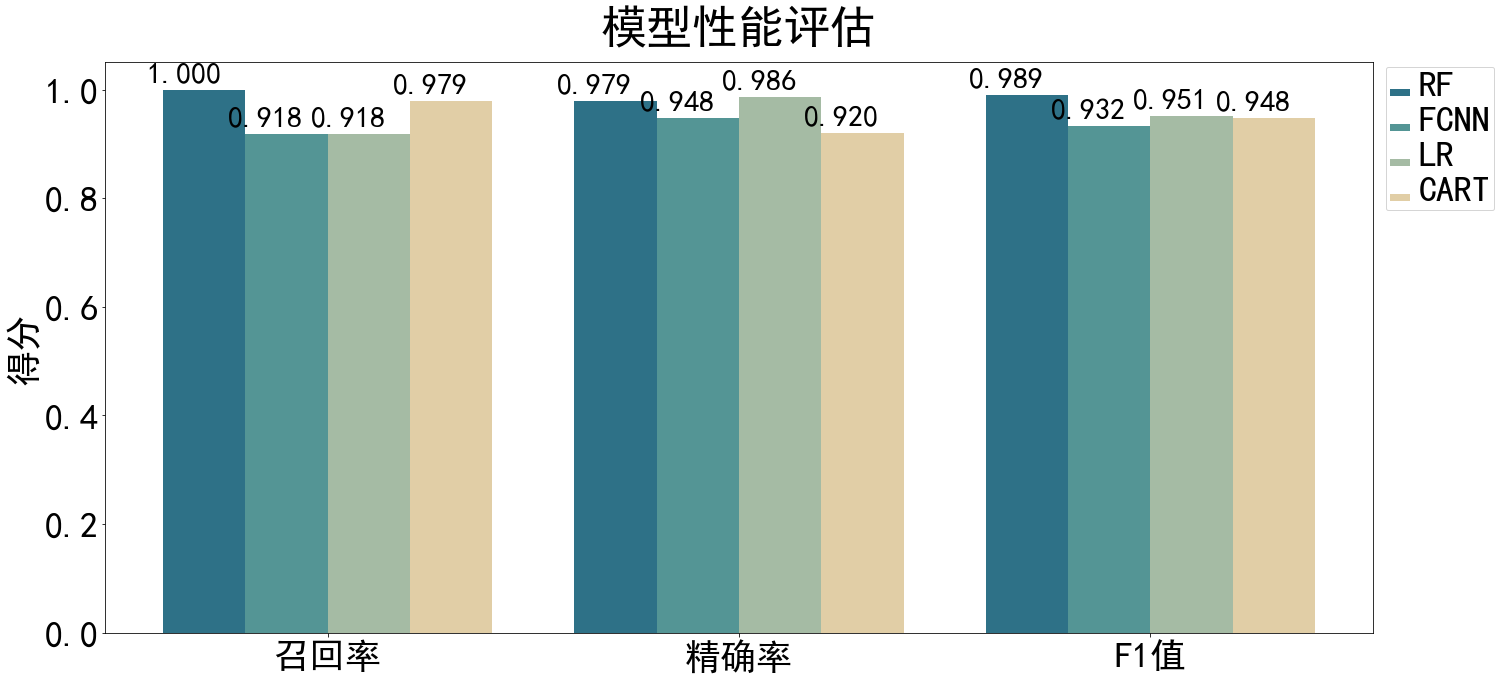

In [273]:
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']

labels = ["召回率", "精确率", "F1值"]


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5 * width, RF_means, width, label="RF", color="#2E7187")
rects2 = ax.bar(x - 0.5 * width, FCNN_means, width, label="FCNN", color="#549595")
rects3 = ax.bar(x + 0.5 * width, LR_means, width, label="LR", color="#A5BBA4")
rects4 = ax.bar(x + 1.5 * width, CART_means, width, label="CART", color="#E1CEA6")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("得分")
ax.set_title("模型性能评估",pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{:.3f}".format(height),
            xy=(rect.get_x() + rect.get_width() / 4, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=30,
        )


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# legend location
ax.legend(loc=1, bbox_to_anchor=(1.1, 1))
# set fontsize
for item in (
    [ax.xaxis.label, ax.yaxis.label]
    + ax.get_xticklabels()
    + ax.get_yticklabels()
    + ax.get_legend().texts
):
    item.set_fontsize(36)
ax.title.set_fontsize(46)
# adjust figure larger
fig.set_size_inches(22, 22 * 0.8)

fig.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.05)


plt.show()
